Hui Yu's answers to these three questions.

What was your biggest challenge in this project? (regarding writing code and not only)

The biggest challenge is to understand K-means. It took me quite a while to read through the file and understand the concept. I was quite confused at begining why the accuracy number is different each time I ran. I will remember to set up random_state to make my results reproducible. 

What did you learn while working on this project? (regarding writing code and not only)

I noticed that the KMeans method is acturally very common used. In my own single cell analysis, the k-mean is widely used to cluster cells and generate UMAP plot.I was not fully aware of it until I read through the kmean document from this project. 
When seperating train and test datasets, I was thinking to manually seperate half dataset for train dataset and half for test dataset, however, my group member used  sklearn.model_selection train_test_split function. Very smart. 


If you had more time on the project what other question(s) would you like to answer? (at least one question is required)

I would like to compare the three accuracy numbers and investigate why I got the highest accuracy score at the train dataset and why the accuracy scores have this trend in the three tests? What can be possibly done to improve the accuracy score (from both sample collections and fitting to approprate model point of views)?

----------------------------------------------------------------------------------------------------------------

Keagan Moo's answers to the three questions:

What was your biggest challenge in this project? (regarding writing code and not only)

The biggest coding challenge was wrapping my head around the structure of the GEOParse object and making sure I was getting the correct pieces out of it. 

What did you learn while working on this project? (regarding writing code and not only)

I learned that sklearn designates its own internal state for reproducibility rather than depending on the environment for the seed. That had not been my experience with similar tools in R or Python so it was good to know. 

If you had more time on the project what other question(s) would you like to answer? (at least one question is required)

I'd like to ask if a consensus model of some kind could be generated by training the model with thirds of the data and combining the results in some meaningful way. Then of course I'd like to know how that stacks up against other methods.


Maya Bose question responses
1. My biggest challenge for the project was understanding how the part of the project I was working on fit into the bigger picture of the assignment. I had never worked on coding projects in groups before, and so learning how to understand what other people's code was doing and how to work with it was very new to me. 

2. I learned that scikit learn has a function for dividing a dataset into a testing set and a training set called test_train_split. 

3. If I had more time to work of the project, I would like to explore what parameters may optimize the accuracy of the KMeans clustering, or explore if there are other classification methods that may fit the situation better. 

In [1]:
import GEOparse
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
random_seed = 3

In [2]:
rawDataGSE10245 = GEOparse.get_GEO(geo="GSE10245", destdir="./")

07-Dec-2021 10:36:11 DEBUG utils - Directory ./ already exists. Skipping.
07-Dec-2021 10:36:11 INFO GEOparse - File already exist: using local version.
07-Dec-2021 10:36:11 INFO GEOparse - Parsing ./GSE10245_family.soft.gz: 
07-Dec-2021 10:36:11 DEBUG GEOparse - DATABASE: GeoMiame
07-Dec-2021 10:36:11 DEBUG GEOparse - SERIES: GSE10245
07-Dec-2021 10:36:11 DEBUG GEOparse - PLATFORM: GPL570
/home/mbose/miniconda3/lib/python3.9/site-packages/GEOparse/GEOparse.py:545: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  table_data = parse_table_data(gpl_soft)
07-Dec-2021 10:36:12 DEBUG GEOparse - SAMPLE: GSM258551
07-Dec-2021 10:36:12 DEBUG GEOparse - SAMPLE: GSM258552
07-Dec-2021 10:36:12 DEBUG GEOparse - SAMPLE: GSM258553
07-Dec-2021 10:36:12 DEBUG GEOparse - SAMPLE: GSM258554
07-Dec-2021 10:36:13 DEBUG GEOparse - SAMPLE: GSM258555
07-Dec-2021 10:36:13 DEBUG GEOparse - SAMPLE: GSM258556
07-Dec-2021 10:36:13 DEBUG GEOparse - SAMPLE: GSM25855

In [3]:
slowpoke = True
if slowpoke:
    print(type(rawDataGSE10245))
    print(rawDataGSE10245.metadata['summary'][0])
    print("\nSample GSM258551")
    for metaIndex in rawDataGSE10245.gsms.get("GSM258551").metadata.items():
        print(str(metaIndex))
    print("\nPlatform GPL570")
    for metaIndex in rawDataGSE10245.gpls.get('GPL570').metadata.items():
        print(str(metaIndex))

<class 'GEOparse.GEOTypes.GSE'>
Non-small cell lung cancer (NSCLC) can be classified into the major subtypes adenocarcinoma (AC) and squamous cell carcinoma (SCC) subtypes. Although explicit molecular, histological and clinical characteristics have been reported for both subtypes, no specific therapy exists so far. However, the characterization of suitable molecular targets holds great promises to develop novel therapies in NSCLC. In the present study, global gene expression profiling of 58 human high grade NSCLC specimens revealed large transcriptomic differences between AC and SCC subtypes: More than 1.700 genes were found to be differentially expressed.

Sample GSM258551
('title', ['NSCLC_AC_10'])
('geo_accession', ['GSM258551'])
('status', ['Public on Oct 01 2009'])
('submission_date', ['Jan 23 2008'])
('last_update_date', ['Aug 28 2018'])
('type', ['RNA'])
('channel_count', ['1'])
('source_name_ch1', ['human non-small cell lung cancer tumor tissue'])
('organism_ch1', ['Homo sapien

In [4]:
rawDataGSE10245.gsms.get('GSM258551').table

,ID_REF,VALUE
0,1007_s_at,9.129905
1,1053_at,8.034022
2,117_at,3.564520
3,121_at,4.746490
4,1255_g_at,2.320698
...,...,...
54670,AFFX-r2-Ec-bioC-5_at,10.730983
54671,AFFX-r2-Ec-bioD-3_at,13.599488
54672,AFFX-r2-Ec-bioD-5_at,13.031726
54673,AFFX-r2-P1-cre-3_at,15.028729


In [5]:
# So to get a useable dataframe we will join each sample together iteratively. 
# Another, possibly faster, method would be to check if all of the rows are the same in each file, but this
# solution is more generalizable in the case where some rows might be filtered out of some samples
dfList = list()
# First we will iterate over all of the samples avialable in the object
for sampleIndex in rawDataGSE10245.gsms:
    # Get the current sample table from the larger object
    sampleData = rawDataGSE10245.gsms.get(sampleIndex).table
    # get the rownames for assignment to the dataframe
    rowNames = sampleData['ID_REF']
    # get the actual data for assignment to the dataframe
    colData = sampleData['VALUE']
    # initialize a temporary dataframe just for the sample and include that samples data with
    # the sample number as the column head
    sampleDataFrame = pd.DataFrame({sampleIndex:colData})
    # reattatch the row names as the index for this temporary dataframe to perserve this sample's
    # reference structure on the off chance they are different between samples
    sampleDataFrame.index = rowNames
    # add this temporary dataframe to the list of all samples' temporary dataframes
    dfList.append(sampleDataFrame)
# Join all temporary dataframes together by index in one step starting with the first and then 
# joining all others in the list.
rawDataFrameGSE10245 = dfList[0].join(dfList[1:])

In [6]:
print(rawDataFrameGSE10245)
rawDataFrameGSE10245.to_csv(r'BiorawDataFrameGSE10245.csv')

                      GSM258551  GSM258552  GSM258553  GSM258554  GSM258555  \
ID_REF                                                                        
1007_s_at              9.129905   9.843349   9.730661   9.032165  10.281793   
1053_at                8.034022   7.973332   8.834045   7.723965   9.040800   
117_at                 3.564520   4.994852   5.066018   4.958580   4.951835   
121_at                 4.746490   5.197306   5.234618   6.078180   5.205632   
1255_g_at              2.320698   2.248520   2.259504   2.262787   2.207531   
...                         ...        ...        ...        ...        ...   
AFFX-r2-Ec-bioC-5_at  10.730983   9.719266   9.101115   9.763076   9.651785   
AFFX-r2-Ec-bioD-3_at  13.599488  12.847711  12.384142  12.969199  12.924465   
AFFX-r2-Ec-bioD-5_at  13.031726  12.250033  11.798363  12.307684  12.243207   
AFFX-r2-P1-cre-3_at   15.028729  14.440756  14.439887  14.557363  14.612223   
AFFX-r2-P1-cre-5_at   14.586347  14.072366  14.01139

In [7]:
df= rawDataFrameGSE10245.T

In [8]:
# Then we need to generate a K-means object using the appropriate number (k) of means
# Thanks to Hui for identifying the need for the "random_state" parameter to reproduce results.
# When actually using this method you would remove this parameter so as not to risk selecting results.
kmeansInit = KMeans(n_clusters = 2,random_state=random_seed)
# We give the kmeans object the data in question to generate the cluster points
kmeansInit.fit(df)
# Finally we ask it to predict the data used to train it and generate the cluster codes for each sample
GSE10245Means = kmeansInit.predict(df)
# Let's attach these values to a Series labeled with the sample names for the benefit of those who follow
GSE10245ClusterCodes = pd.Series(GSE10245Means, index = df.index)
GSE10245ClusterCodes.to_csv(r'clusterCodesGSE10245.csv')

In [9]:
GSE10245Means

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0], dtype=int32)

In [10]:
df.head()

ID_REF,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,...,AFFX-r2-Bs-thr-M_s_at,AFFX-r2-Ec-bioB-3_at,AFFX-r2-Ec-bioB-5_at,AFFX-r2-Ec-bioB-M_at,AFFX-r2-Ec-bioC-3_at,AFFX-r2-Ec-bioC-5_at,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at
GSM258551,9.129905,8.034022,3.564520,4.746490,2.320698,5.519153,3.339182,2.775395,8.303437,2.981327,...,10.297589,8.857847,9.369037,9.435077,10.936404,10.730983,13.599488,13.031726,15.028729,14.586347
GSM258552,9.843349,7.973332,4.994852,5.197306,2.248520,5.081258,2.934516,2.617097,9.145519,4.619668,...,8.217455,7.865127,8.116953,8.306683,9.986505,9.719266,12.847711,12.250033,14.440756,14.072366
GSM258553,9.730661,8.834045,5.066018,5.234618,2.259504,4.657257,3.007192,2.634559,9.159054,2.746464,...,8.713199,6.996104,7.803869,8.029131,9.468096,9.101115,12.384142,11.798363,14.439887,14.011392
GSM258554,9.032165,7.723965,4.958580,6.078180,2.262787,4.535683,3.167112,3.127495,7.770354,6.212399,...,8.805233,8.221659,8.434090,8.609512,10.064087,9.763076,12.969199,12.307684,14.557363,14.162145
GSM258555,10.281793,9.040800,4.951835,5.205632,2.207531,3.731919,2.711790,2.707079,6.380928,4.528499,...,8.285092,8.042156,8.174685,8.620098,10.005558,9.651785,12.924465,12.243207,14.612223,14.122751


In [11]:
## this code is adapted from Maya Bose's original code
rawDataGSE10245 = GEOparse.get_GEO(filepath="GSE10245_family.soft.gz", silent=True)
tumor_subtypes = list()
for sample in rawDataGSE10245.gsms:
    tumor_subtype = rawDataGSE10245.gsms.get(sample).metadata['characteristics_ch1'][0].split(":")[1].strip()
    if tumor_subtype == "adenocarcinoma":
        tumor_subtypes.append("AD")
    elif tumor_subtype == "squamous cell carcinoma":
        tumor_subtypes.append("SCC")
    else:
        tumor_subtypes.append("UNKNOWN")
df = df.assign(tumor_subtype = tumor_subtypes)
GSE10245ClusterCodes = GSE10245ClusterCodes.to_frame().assign(tumor_subtype = tumor_subtypes)

/home/mbose/miniconda3/lib/python3.9/site-packages/GEOparse/GEOparse.py:545: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  table_data = parse_table_data(gpl_soft)


In [12]:
GSE10245ClusterCodes

,0,tumor_subtype
GSM258551,0,AD
GSM258552,0,AD
GSM258553,1,SCC
GSM258554,0,AD
GSM258555,1,SCC
GSM258556,0,SCC
GSM258557,1,SCC
GSM258558,0,AD
GSM258559,0,AD
GSM258560,0,AD


In [13]:
## for problem 3, create a dataframe contains 58 sampes labels, cluster number and subtypes
GSE10245ClusterCodes.columns =['Cluster_Number','Tumor_Subtype']
GSE10245ClusterCodes.index.names=["Sample_Name"]
GSE10245ClusterCodes.to_csv(r'cluster_tumor_type_infor.csv') 
## problem 3 is done

In [14]:
GSE10245ClusterCodes.head()

,Cluster_Number,Tumor_Subtype
Sample_Name,,
GSM258551,0,AD
GSM258552,0,AD
GSM258553,1,SCC
GSM258554,0,AD
GSM258555,1,SCC


In [15]:
# for problem 4, Compute and display the accuracy of this clustering.
## first set up "SCC" = 1 and "AD" = 0
GSE10245Means
GSE10245Means = np.where(GSE10245Means == 0, "AD", "SCC")

In [16]:
GSE10245Means

array(['AD', 'AD', 'SCC', 'AD', 'SCC', 'AD', 'SCC', 'AD', 'AD', 'AD',
       'AD', 'AD', 'SCC', 'AD', 'SCC', 'SCC', 'AD', 'AD', 'AD', 'SCC',
       'AD', 'AD', 'AD', 'AD', 'AD', 'AD', 'AD', 'SCC', 'AD', 'AD', 'AD',
       'AD', 'SCC', 'AD', 'SCC', 'AD', 'AD', 'AD', 'AD', 'SCC', 'AD',
       'AD', 'SCC', 'SCC', 'AD', 'SCC', 'AD', 'AD', 'SCC', 'AD', 'AD',
       'AD', 'SCC', 'AD', 'AD', 'AD', 'AD', 'AD'], dtype='<U3')

In [17]:
## want to check the overal accuracy by adding the predicted subtype in the dataframe
df_2 = GSE10245ClusterCodes.assign(predicted=GSE10245Means)

In [18]:
df_2.head()

,Cluster_Number,Tumor_Subtype,predicted
Sample_Name,,,
GSM258551,0,AD,AD
GSM258552,0,AD,AD
GSM258553,1,SCC,SCC
GSM258554,0,AD,AD
GSM258555,1,SCC,SCC


In [19]:
complete_dataset_acc = accuracy_score(tumor_subtypes, GSE10245Means)

In [20]:
print(f"The accuracy score when testing on all of the data is {complete_dataset_acc}.")

The accuracy score when testing on all of the data is 0.9310344827586207.


Lets partition our df into AD and SCC samples. randomly choose 20 AD samples and 9 SCC sample. We will designate these the "test" set. The remainder of the samples will be the "validation" set.

In [21]:
ad = df[df["tumor_subtype"] == "AD"]
scc = df[df["tumor_subtype"] == "SCC"]
print(f"There are {ad.shape[0]} AD samples and {scc.shape[0]} SCC samples")

There are 40 AD samples and 18 SCC samples


We want to use half of the AD samples as our "training" set, and the other half as our "testing" set. Ditto for the SCC samples. We can use the sklearn.model_selection train_test_split function to do this. test_size indicates the ratio of training samples to testing samples; in this case, the ratio is 50:50 (half).

In [22]:
train_ad, test_ad = train_test_split(ad, test_size = 0.5, random_state = random_seed)
train_scc, test_scc = train_test_split(scc, test_size = 0.5, random_state = random_seed)

Let's combine our "training" set for AD samples with our "training" set for SCC samples into a single training set. Do the same to create a single testing set. We also want to remove the tumor subtype annotations, so that we can then use the model to predict these annotations, but we will also save the labels in a seperate variable for testing the accuracy of the model later.

In [23]:
# Combine AD training samples with SCC training samples to create a single training DF
train = pd.concat([train_ad, train_scc])
# Save the tumor subtype labels for accuracy testing later
train_labels = train["tumor_subtype"].values
# drop the tumor subtype labels to use the DF in clustering
train = train.drop("tumor_subtype", axis = 1)

# Combine AD testing samples with SCC testing samples to create a single testing DF
test = pd.concat([test_ad, test_scc])
# Save the tumor subtype labels for accuracy testing later
test_labels = test["tumor_subtype"].values
# drop the tumor subtype labels to use the DF in clustering
test = test.drop("tumor_subtype", axis = 1)

In [24]:
# Check out what one of these DFs looks like to make sure everything's good
train.head()

ID_REF,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,...,AFFX-r2-Bs-thr-M_s_at,AFFX-r2-Ec-bioB-3_at,AFFX-r2-Ec-bioB-5_at,AFFX-r2-Ec-bioB-M_at,AFFX-r2-Ec-bioC-3_at,AFFX-r2-Ec-bioC-5_at,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at
GSM258598,9.871776,7.469301,3.583423,5.736595,2.225399,4.302100,2.963642,2.599405,6.248514,4.227329,...,8.912983,8.379795,8.786520,8.760903,10.232256,9.824295,13.162891,12.446226,14.703199,14.231290
GSM258554,9.032165,7.723965,4.958580,6.078180,2.262787,4.535683,3.167112,3.127495,7.770354,6.212399,...,8.805233,8.221659,8.434090,8.609512,10.064087,9.763076,12.969199,12.307684,14.557363,14.162145
GSM258586,8.757455,6.958085,5.339252,5.193266,5.535001,5.132130,2.973675,2.607981,8.864519,2.723080,...,10.209200,8.472484,8.856784,8.997555,10.459636,10.111940,13.365125,12.720290,14.852756,14.426513
GSM258577,8.711734,8.604424,6.845243,5.207483,2.694211,4.768066,3.032224,2.657855,8.724363,3.388218,...,9.527837,6.362626,6.053217,6.575966,8.208702,8.028383,11.462046,10.570192,13.575853,13.007838
GSM258574,8.914079,8.232630,6.634602,5.086281,2.212639,5.626913,2.949485,2.578616,9.465973,4.645915,...,9.503383,7.862734,8.362031,8.540746,10.206568,9.676948,13.081193,12.531710,14.738462,14.298989


Now, we can train the model using the training set

In [25]:
# Train the model
kmeansInit.fit(train)

# Use the trained model to predict tumor states in the training set
train_kmeans = kmeansInit.predict(train)
# Use the trained model to predict tumor states in the testing set
test_kmeans = kmeansInit.predict(test)

In [26]:
# Check out what the clusters look like
train_kmeans 

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0], dtype=int32)

We will map the 0 cluster to AD and the 1 cluster to SSC.

In [27]:
train_kmeans = np.where(train_kmeans == 0, "AD", "SCC")
test_kmeans = np.where(test_kmeans == 0, "AD", "SCC")

In [28]:
train_kmeans

array(['AD', 'AD', 'AD', 'AD', 'AD', 'AD', 'AD', 'AD', 'SCC', 'AD', 'AD',
       'AD', 'AD', 'AD', 'AD', 'AD', 'AD', 'AD', 'AD', 'AD', 'SCC', 'SCC',
       'SCC', 'SCC', 'SCC', 'SCC', 'SCC', 'SCC', 'AD'], dtype='<U3')

Neat. Step 5 completed! Now for step 6 (computing and displaying the accuracy of the model for the training and testing data). We can do this by using sklearn.metrics functions accuracy_score to compare the known labels (stored in variables earlier) to the cluster predictions.
Accuracy score for the training data set:

In [29]:
print(f"The accuracy score when training on half of the data is {accuracy_score(train_labels, train_kmeans)}.")
training_acc = accuracy_score(train_labels, train_kmeans)

The accuracy score when training on half of the data is 0.9310344827586207.


Accuracy score for the testing data set:

In [30]:
print(f"The accuracy score when testing on half of the data is {accuracy_score(test_labels, test_kmeans)}.")
testing_acc = accuracy_score(test_labels, train_kmeans)

The accuracy score when testing on half of the data is 0.896551724137931.


The three numbers we need to plot are 0.9310344827586207 for  complete dataset, 0.9310344827586207 for training dataset, and 0.896551724137931 for testing dataset


In [31]:
## create a bar chart and 
## assign the name for each bar 
names = ['complete_dataset','training_dataset','testing_dataset']

In [32]:
## assigne the accuracy_score to each bar 
values = [complete_dataset_acc, training_acc, testing_acc]

Text(0.5, 1.0, 'Plot the 3 accuracy values')

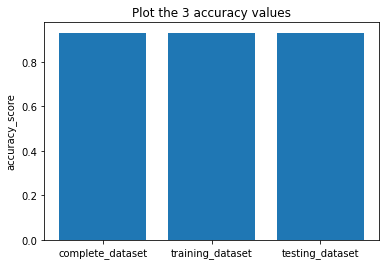

In [33]:
plt.bar(names, values)
plt.ylabel('accuracy_score')
plt.title('Plot the 3 accuracy values')

In [34]:
plt.savefig('plot_3_accuracy_values.png')

<Figure size 432x288 with 0 Axes>